<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S33_vacuum_sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -U -q gtbook


Note: you may need to restart the kernel to use updated packages.


In [2]:
import gtsam

import gtbook
import gtbook.display
from gtbook import vacuum
from gtbook.discrete import Variables
VARIABLES = Variables()
def pretty(obj):
    return gtbook.display.pretty(obj, VARIABLES)
def show(obj, **kwargs):
    return gtbook.display.show(obj, VARIABLES, **kwargs)


In [3]:
# From section 3.2:
wxyz = gtsam.DiscreteBayesNet()
W1 = VARIABLES.binary("W")
X1 = VARIABLES.binary("X")
Y1 = VARIABLES.binary("Y")
Z1 = VARIABLES.binary("Z")
wxyz.add(W1, [X1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(X1, [Y1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(Y1, [Z1], "1/1 1/1")
wxyz.add(Z1, "1/1")

N = 5
X = VARIABLES.discrete_series("X", range(1, N+1), vacuum.rooms)
A = VARIABLES.discrete_series("A", range(1, N), vacuum.action_space)


# Dynamic Bayes Nets

> Dynamic Bayes nets replicate a Bayes net fragment over time.

<img src="Figures3/S33-iRobot_vacuuming_robot-01.jpg" alt="Splash image with balancing steampunk robot sporting big eyes" width="40%" align=center style="vertical-align:middle;margin:10px 0px">


The Markov chain over successive states $X_t$ we discussed in the previous section is an example of a **Dynamic Bayes Net** or **DBN**: a Bayes net in which  *Bayes net slices* are replicated through time, to model the evolution of states over time. Below we add observations into the mix, and show how we can simulate the complete system using a technique called *ancestral sampling*.

## A Sensor Model

> A simple light sensor

This chapter is primarily focused on action, and hence the sensing we will consider is fairly simple. Let us conceive of a simple light sensor that gives an indication as to which room we are in. Specifically, let us assume that the living room and kitchen are on the south side, and hence have a lot of light on a typical day. The office in the dining room or on the north side, and the light sensor will typically respond with medium light levels. The hallway, on the other hand, is very dark as it has few windows. We can capture these semantics with a conditional probability distribution $P(Z_t|X_t)$, where $X_t$ is the state at time $t$ as before, and $Z_t\in\{\text{dark}, \text{medium}, \text{light}\}$ is the measured light level. 

A small code snippet can create a reasonable sensor model:

In [10]:
# vacuum.light_levels = ["dark", "medium", "light"]
Z = VARIABLES.discrete_series("Z", range(1, N+1), vacuum.light_levels) # define variables
# vacuum.sensor_spec = "1/1/8 1/1/8 2/7/1 8/1/1 1/8/1"
pretty(gtsam.DiscreteConditional(Z[1], [X[1]], vacuum.sensor_spec)) # CPT on Z1 at time t=1


X1,dark,medium,light
Living Room,0.1,0.1,0.8
Kitchen,0.1,0.1,0.8
Office,0.2,0.7,0.1
Hallway,0.8,0.1,0.1
Dining Room,0.1,0.8,0.1


## Dynamic Bayes Nets

> AXZ slices for the win!

Single time step reasoning will fall short for our vacuuming robot, which operates in time. For example, recall the maximum likelihood method from the previous chapter, which we could try to apply here. In our case, given a sensor reading of, say, $Z_1$=`medium`, the maximum likelihood estimate (MLE) for the state $X_1$ of the robot is `dining room`: it corresponds to the highest value in the `medium` column. But that takes only one measurement into account, even if we take many steps in the environment.
Intuitively, we should be able to use the robot's history to obtain a better estimate of its location. For example, if the robot were just in the living room, there is no way that it could have gotten to the dining room in a single step. In this section we will see how we can reason probabilistically about such things.

We use a **dynamic Bayes net** to reason about this, which is a special type of Bayes net.
Recall that directed cycles are not allowed in a Bayes net, i.e., the
graph is acyclic. Hence, one might wonder how we deal with time: if a
robot is all about the sense-think-act cycle, would we not expect a
cycle in the graph when describing robots? The answer is to *unroll* time,
as we show below.
When a Bayes net is used to unroll the evolution of a system or agent
over time, we call it a dynamic Bayes net or **DBN**. 

To illustrate this we will once again resort to code. The following piece of code builds the entire vacuuming robot dynamic Bayes net. Note that we take care to add CPTs of variables *before* we add the CPT on any of their parents (hence the `reversed` below) for reasons that will soon become clear:

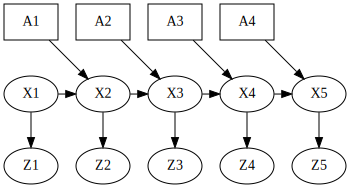

In [11]:
dbn = gtsam.DiscreteBayesNet()
for k in range(1,N+1):
    dbn.add(Z[k], [X[k]], vacuum.sensor_spec) # Add measurement CPTs
for k in reversed(range(1, N)):
    dbn.add(X[k+1], [X[k], A[k]], vacuum.action_spec) # Add transition CPTs
dbn.add(X[1], "1/1/1/1/1") # Add initial state CPT

show(dbn, hints={"A":2, "X":1, "Z":0}, boxes={A[k][0] for k in range(1,N)})


Observe that after the first time step, the Bayes net is repeating the same "AXZ" pattern (or *slice*!) over and over again. Formally, the joint distribution $P(Z_{1:n},X_{1:n}|A_{1:n})$ over states $X_{1:n} = (X_1 \dots, X_n)$ and measurements $Z_{1:n} = (Z_1, \dots , Z_n)$, *given* 
the action sequence $A_{1:n} = (A_1, \dots , A_n)$ is defined as

$$
P(Z_{1:n},X_{1:n}|A_{1:n})= P(Z_1| X_1) P(X_1) \prod_{k=2}^{n} P(Z_k| X_k) P(X_k|A_{k-1},X_{k-1}).
$$

The AXZ slice at time $k$ is given by $P(Z_k| X_k) P(X_k|A_{k-1},X_{k-1})$, whereas the chain is "jump-started" using the initial state distribution $P(X_1)$ and the corresponding measurement model $P(Z_1|X_1)$.

## Ancestral Sampling

> Ancestry matters!

How do we sample over such a complex Bayes net? Recall the example Bayes net example above with the four variables W,X,Y,Z, and joint distribution 

$$P(W,X,Y,Z)=P(W|X,Z)P(X|Y,Z)P(Y|Z)P(Z):$$ 

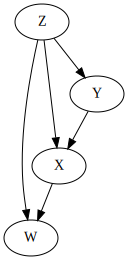

In [13]:
show(wxyz)


Sampling from the joint distribution given in Bayes net form can be done
by sampling each variable in turn, but making sure that we always sample
a node’s parents first. This can be done through the notion of a
**topological sort** of the DAG. A topological sort of a DAG is an ordering
of the vertices $\{v_1, \dots , v_n\}$ such that $v_i$ precedes $v_j$ in the sort when there
is a directed edge from $v_i$ to $v_j$ in the DAG.

An easy algorithm to obtain a topological sort is **Kahn’s algorithm**,
which iteratively removes nodes from the graph that either have no
parents, or whose parents have all been removed already. The order in
which nodes are removed constitutes a (non-unique) topological sort
order.

Sampling is then done by inverse transform sampling for each variable
separately, in topological sort order. The graph above happens to be laid out already in topological sort order, if read from top to bottom.
Hence, in this example we sample first $Z$, then $Y$, then $X$, and then
$W$. Note that in this case the topological sort is unique, but that is
an exception rather than the rule: for arbitrary Bayes nets, more than one topological sort can exist.

## Simulation of a Robot

> Simulation as sampling, once again!

Simulation of a robot is then equivalent
to ancestral sampling from the DBN associated with the robot, i.e., the controlled Markov chain augmented with the measurement CPTs.
In this case one topological sort is
rather obvious, and so is a simulation algorithm to sample from 
$P(X_{1:n},Z_{1:n}|A_{1:n})$:

1. First, assign $k\leftarrow1$, and sample the initial state $x_1$ from $P(X_1)$, a prior
    over the state. We write

    $$x_1 \sim P(X_1)$$

2. Next, simulate the sensor reading by sampling from the sensor model
    
    $$z_{k} \sim P(Z_{k}|X_{k}=x_{k})$$

3. Lastly, simulate the effect of the (given) action $a_k$ by sampling the next state $x_{k+1}$:

    $$x_{k+1} \sim P(X_{k+1}|X_{k}=s_{k},A_{k}=a_{k}).$$

4. Increase $k\leftarrow k+1$ and return to step $2$.

Note that this algorithm is generic for all robot models with this action/sensing structure.

### Exercises

1. Simulate two different realizations from the dynamic Bayes net above.

1. Think of a different way to topologically sort the graph, and the corresponding sampling algorithm.

## Ancestral Sampling with GTSAM
Of course, GTSAM has a method built in to do ancestral sampling, *but* it only works for a *reverse* topologically sorted Bayes nets. This matches the way we write down joint distributions, with parents towards the right, and it is also why above we used the built-in `reversed` on the range: this was to make sure that later states get sampled last. Because in our code above we only specified
$P(Z_{1:n},X_{1:n}|A_{1:n})$, we need to give an action sequence $a_{1:n}$ as an argument. Below we examine what happens when we try the action `Right` 4 times in a row:

In [16]:
actions = VARIABLES.assignment({A[k]: "R" for k in range(1,N)})
pretty(dbn.sample(actions))


Variable,value
A1,R
A2,R
A3,R
A4,R
X1,Hallway
X2,Dining Room
X3,Dining Room
X4,Dining Room
X5,Dining Room
Z1,dark


The actions are included in the resulting `DiscreteValues` instance, so we have a complete picture of one sampled "world state" over time. Note that it now not only includes the states $X_k$ over time, but also the sampled measurements $Z_k$ at each time step. Not surprisingly, we quickly transition from the dark hallway to the slight brighter dining room, and get stuck there, as there is no room to the right of the dining room!

### Exercises

- Execute the cell above multiple times and observe you *do* get different realizations (almost) every time.
- Try doing the same with different action sequences.
- Try formulating an action sequence that gets you to the kitchen. Does it always succeed?

## GTSAM 101
> The GTSAM concepts used in this section, explained.

We use the `gtsam.DiscreteBayesNet` method `sample`, with signature

```python
    sample(self, given: gtsam::DiscreteValues) -> gtsam::DiscreteValues
```

It implements ancestral sampling, but assumes the Bayes net is reverse topologically sorted, i.e. last
conditional will be sampled first. In addition, it can optionally take an assignment for certain *given* variables.
In that case, it is also assumed that the Bayes net does not contain any conditionals for the given values.
We used this functionality to pass the given action sequence above.